# Informer Demo

## Download code and dataset

In [58]:
import sys
sys.path.append('바탕화면/Informer2020')

In [4]:
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

## KDD99 전처리

In [12]:
import numpy as np
import pandas as pd
train_data = np.load('./dataset/KDD99/npy/kdd99_train.npy')[:,:-1]
train_data = pd.DataFrame(train_data)

In [13]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,562387.000000,5.623870e+05,5.623870e+05,562387.0,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,...,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000,562387.000000
mean,7.685348,1.147892e+03,4.017193e+03,0.0,0.000030,0.049893,0.000119,0.023263,0.000391,0.000155,...,133.172776,223.434281,0.924537,0.011313,0.082335,0.024145,0.001403,0.000614,0.032885,0.031245
std,301.013165,4.698139e+04,3.396869e+04,0.0,0.009142,0.943207,0.014668,3.330964,0.019775,0.016601,...,102.288553,67.510807,0.202992,0.050613,0.197267,0.043821,0.021023,0.008790,0.172664,0.168804
min,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.100000e+02,3.310000e+02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.000000,253.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.480000e+02,1.060000e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,114.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.160000e+02,3.040000e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.030000,0.000000,0.000000,0.000000,0.000000
max,40504.000000,1.881556e+07,1.173059e+07,0.0,5.000000,77.000000,4.000000,884.000000,1.000000,2.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train_data.to_csv("./dataset/KDD99/preprocessing/kdd99.csv", mode='w')

In [15]:
train_data = train_data.iloc[:int(len(train_data)*0.7)]

In [17]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(train_data)

import joblib
joblib.dump(scaler, './dataset/KDD99/preprocessing/KDD99_standard_scaler.pkl')

['./dataset/KDD99/preprocessing/KDD99_standard_scaler.pkl']

In [129]:
smap.to_csv("./dataset/SMAP/preprocessing/smap.csv", mode='w')

## Anomaly test set 구성

## Experiments: Informer 시계열 예측 모형

In [9]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [10]:
###################################
# 여기를 보세요
###################################
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'KDD99' # data
args.root_path = './dataset/KDD99/preprocessing/' # root path of data file
args.data_path = 'kdd99.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '2_FQ_601_PV' # target feature in S or MS task
args.freq = 'y' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 6*60 # input sequence length of Informer encoder
args.label_len = 6*30 # start token length of Informer decoder
args.pred_len = 6*10 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# 얘네들은 feature 개수 의미하는건가?
args.enc_in = 34 # encoder input size
args.dec_in = 34 # decoder input size
args.c_out = 34 # output size

args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
#args.e_layers = 4 # 4 # num of encoder layers
args.s_layers = [3,2,1]
args.d_layers = 4 # 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'fixed' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = True # whether to output attention in ecoder
args.mix = True
args.padding = 0
#args.freq = 's'

args.batch_size = 64
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 30
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [11]:
Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}_standard'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # validation
    print('>>>>>>>validation : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.validation(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informerstack_KDD99_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_standard>>>>>>>>>>>>>>>>>>>>>>>>>>
train 393251
val 112419
test 56180
	iters: 100, epoch: 1 | loss: 0.0135687
	speed: 0.4571s/iter; left time: 84202.1578s
	iters: 200, epoch: 1 | loss: 0.0122214
	speed: 0.4726s/iter; left time: 87020.5069s
	iters: 300, epoch: 1 | loss: 0.0093485
	speed: 0.4619s/iter; left time: 84990.6726s
	iters: 400, epoch: 1 | loss: 0.0089390
	speed: 0.4686s/iter; left time: 86182.3140s
	iters: 500, epoch: 1 | loss: 0.0083221
	speed: 0.4695s/iter; left time: 86309.2087s
	iters: 600, epoch: 1 | loss: 0.0078008
	speed: 0.4726s/iter; left time: 86826.8880s
	iters: 700, epoch: 1 | loss: 0.0076731
	speed: 0.4648s/iter; left time: 85341.5199s
	iters: 800, epoch: 1 | loss: 0.0059905
	speed: 0.4590s/iter; left time: 84230.5968s
	iters: 900, epoch: 1 | loss: 0.0066136
	speed: 0.4767s/iter; left time: 87429.5949s
	iters: 1000, epo

## Anomaly detection

In [120]:
import numpy as np
path = './results/informerstack_WADI_ftM_sl60_ll30_pl6_dm512_nh24_elNone_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0_informerstack5'
val_preds = np.load(path+'/val_pred.npy')
val_trues = np.load(path+'/val_true.npy')
test_preds = np.load(path+'/test_pred.npy')
test_trues = np.load(path+'/test_true.npy')

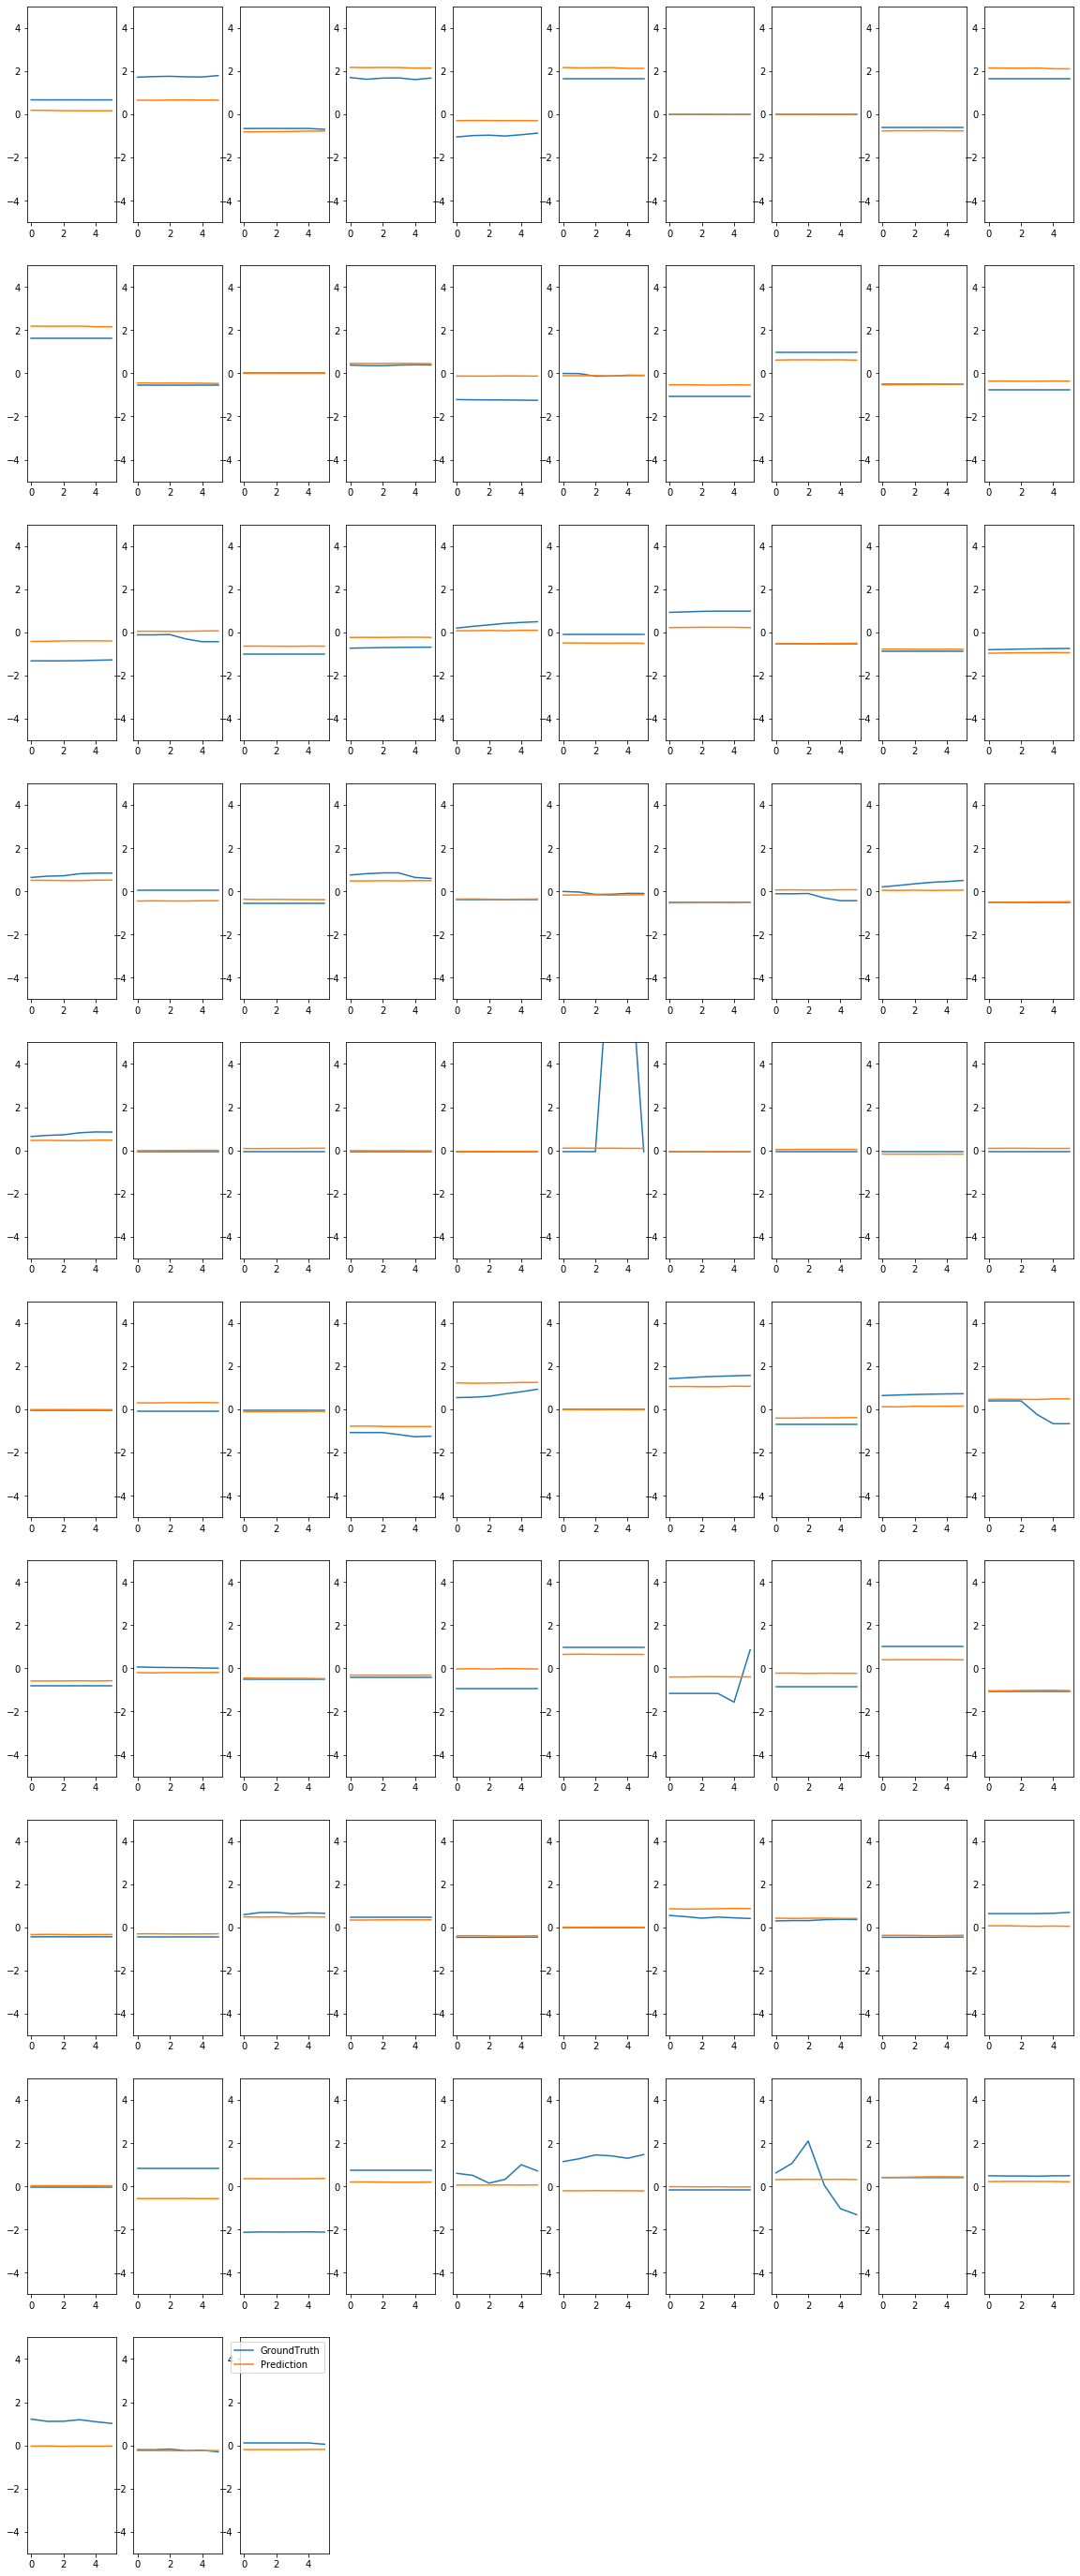

In [121]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 50))

idx = 2880
 
for i in range(args.enc_in):
    plt.subplot(10, 10, i+1)
    plt.ylim([-5.0, 5.0])    
    plt.plot(val_trues[idx,:,i], label='GroundTruth')
    plt.plot(val_preds[idx,:,i], label='Prediction')


plt.legend()
plt.show()